****Unsupervised ML Example: Cyclohexane****

In [15]:
import ase
import os
import sys
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from ase.visualize import view
from matplotlib import pyplot as plt
import matplotlib as mpl
from ase.io import read, write
from sklearn.preprocessing import normalize
from skcosmo.preprocessing import StandardFlexibleScaler
from rascal.representations import SphericalInvariants as SOAP
from sklearn.metrics.pairwise import pairwise_kernels
import numpy as np
from functools import partial

import numpy as np
from openTSNE import TSNE

In [2]:
min_val, max_val = 0.1, 0.8
n = 10
orig_cmap = plt.cm.inferno
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

## Preparing the Data

### Read Data


In [3]:
from ase.io import read

traj = read('./cyclohexane_data/MD2/trajectory.xyz', '20:')

conf_traj = [
    read(f'./cyclohexane_data/conformers/{f}.xyz') for f in
    ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']
]

for frame in [*traj, *conf_traj]:
    frame.wrap(eps=1e-10)
    mask = np.zeros(len(frame))
    mask[np.where(frame.numbers == 6)[0]] = 1
    frame.arrays['center_atoms_mask'] = mask
    
print(len(traj))
    
names = ['chair', 'twist-boat', 'boat', 'half-chair', 'half-boat', 'planar']

10779


In [4]:
energy = np.array([a.info['energy_eV'] for a in traj])
c_energy = np.array([frame.info['energy_eV'] for frame in conf_traj])

In [5]:
max_e = max(c_energy)
min_e = min(c_energy)
scale = max_e - min_e

scaled_energy = (energy - min_e) / scale
scaled_c_energy = (c_energy - min_e) / scale

Here we can confirm what our analysis will tell us: the simulation starts in the planar conformation, transitions to the metastable half-chair and half-boat configurations, then moves through the boat configuration until it ultimately reaches the chair conformation.

No handles with labels found to put in legend.


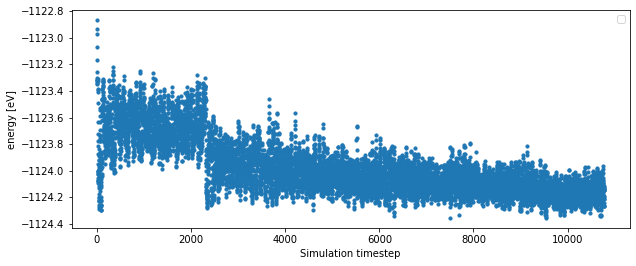

In [6]:
fig, ax = plt.subplots(1, figsize=(10,4))
ax.scatter(range(len(energy)),
            energy,
            s=10,
            cmap='plasma')

ax.set_xlabel("Simulation timestep")
ax.set_ylabel("energy [eV]")
ax.legend()
plt.show()

### Set up Plotting

In [7]:
def plot_embedding(
    embedding,
    conf_embedding,
    idx=range(len(traj)),
    xlabel=r'$PC_1$',
    ylabel=r'$PC_2$',
    coloring=True,
    cbar=True,
):
    fig, ax = plt.subplots(1, figsize=(8, 8 - 2 * int(cbar)))

    p = ax.scatter(*embedding[:, :2].T,
                   zorder=-1,
                   c=energy[idx] if coloring else 'grey',
                   vmax=max_e,
                   vmin=min_e,
                   cmap=cmap,
                   alpha=1.0 if coloring else 0.5,
                   s=4)
    ax.scatter(
        *conf_embedding[:, :2].T,
        c=c_energy if coloring else 'grey',
        s=200,
        ec='k',
        lw=2,
        alpha=0.8,
        vmax=max_e,
        vmin=min_e,
        cmap=cmap,
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if cbar and coloring:
        plt.colorbar(p, label='Energy, eV')

### Create SOAP descriptors 
we create soap descriptor with the help of `rascal` library as below. The main concept is that we use `rcut=2.5` that we are considering 2.5A radius of sphere for describing each atom environments in the structure to get environmental descriptors. But we need one descriptor per structure so we the averaged descriptor| to build a structure level descriptor from the local environment ones. 

In [8]:
hypers = {
    "interaction_cutoff": 2.5,
    "max_radial": 6,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "global_species": [1, 6],
    "expansion_by_species_method": "user defined",
    "normalize": False
}

soap = SOAP(**hypers)
normalizer = StandardFlexibleScaler(column_wise=False, with_std=True)

soaps = normalizer.fit_transform(soap.transform(traj).get_features(soap))
mean_soaps = np.mean(np.split(soaps, len(traj)), axis=1)

conf_soaps = normalizer.transform(soap.transform(conf_traj).get_features(soap))
conf_mean_soaps = np.mean(np.split(conf_soaps, len(conf_traj)), axis=1)

soaps.shape, conf_soaps.shape

((64674, 1080), (30, 1080))

**What if we didn't know the energies or transition states? Let's see if we can detect this transition another way**

## Analysis at global structure level 

### Linear Principal Components Analysis

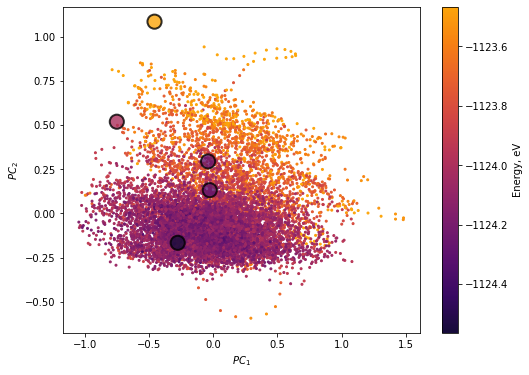

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(mean_soaps)

t_pca = pca.transform(mean_soaps)
t_pca_conf = pca.transform(conf_mean_soaps)

plot_embedding(t_pca, t_pca_conf)

Because of the coloring by energies, we can see two distinct regions corresponding to the two metastable states of the simulation. Without coloring by energy, it's a bit harder to pick up:

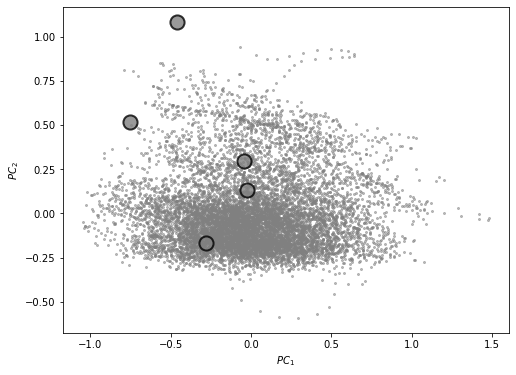

In [10]:
plot_embedding(t_pca, t_pca_conf, coloring=False)

We can use a chemiscope to explore this PCA and its additional dimensions further:

In [11]:
import chemiscope
properties = {"PCA": t_pca}
widget = chemiscope.show(traj, properties)
widget

/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-0.30886277 -0.99127674  5.10652404]' of type '<class 'numpy.ndarray'>' for the 'forces_eV_per_au' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-0.30886277 -0.99127674  5.10652404]' of type '<class 'numpy.ndarray'>' for the 'forces' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 18, "names": ["C", "C", "C"…

### Kernel Principal Components Analysis

In [12]:
from sklearn.decomposition import KernelPCA
from skcosmo.preprocessing import KernelNormalizer

When building a kernel on **averaged** representations, we construct our kernel such that

$$K(\mathcal{X}_A, \mathcal{X}_{B}) = \frac{\sum_{i \in A} \sum_{j \in B} k\left(\mathcal{X}_i, \mathcal{X}_j\right)}{N_A N_B}$$

where the kernel between structures $A$ and $B$ is the average of the kernels of each of their atomic environments. With non-linear kernels, this is not equal to the kernel of the averaged representations, i.e.

$$K(\mathcal{X}_A, \mathcal{X}_B) \neq k\left(\sum_{i\in A}\frac{\mathcal{X}_i}{N_A}, \sum_{j\in B}\frac{\mathcal{X}_j}{N_B}\right)$$


**If you want to speed up this section, which can take a while:**

For the sake of simplicity, we can use a subset of the data points, just un-comment the lines marked "simplify" and comment those marked "full calculation". 

In [13]:
# idx = np.random.choice(range(len(traj)), 4000, replace=False) # simplify
# atom_idx = np.concatenate([range(i*6, (i+1)*6) for i in idx]) # simplify

idx = np.arange(len(traj)) # full calculation
atom_idx = np.arange(len(soaps)) # full calculation

In [23]:
kernel = partial(pairwise_kernels, metric='rbf', gamma=1, n_jobs=4)

# because we know that atom-ordering is conserved in this trajectory,
# we'll only consider comparisons between identical atom indices
# this would correspond with a `best-match` kernel
K = np.zeros((len(idx), len(idx)))
for i in tqdm(range(len(traj))):
    ki = kernel(soaps[i * 6:(i + 1) * 6], soaps[i * 6:])
    for j in range(i, len(traj)):
        K[i, j] = K[j, i] = np.mean(np.diag(ki[:,
                                               (j - i) * 6:(j - i + 1) * 6]))

K.shape

  0%|          | 0/10779 [00:00<?, ?it/s]

(10779, 10779)

In [29]:
conf_K = np.zeros((5, len(idx)))
for i in tqdm(range(len(conf_traj))):
    ki = kernel(conf_soaps[i * 6:(i + 1) * 6], soaps)
    for j in range(len(traj)):
        conf_K[i, j] = np.mean(np.diag(ki[:, j * 6:(j + 1) * 6]))

  0%|          | 0/5 [00:00<?, ?it/s]

In [36]:
kn = KernelNormalizer(with_trace=False).fit(K)
K = kn.transform(K)
conf_K = kn.transform(conf_K)

In [37]:
kpca = KernelPCA(n_components=10, kernel='precomputed')
kpca.fit(K)

KernelPCA(kernel='precomputed', n_components=10)

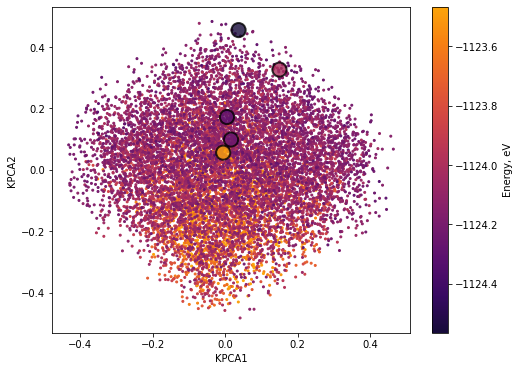

In [38]:
t_kpca = kpca.transform(K)
t_kpca_conf = kpca.transform(conf_K)

plot_embedding(t_kpca, t_kpca_conf, idx=idx, xlabel='KPCA1', ylabel='KPCA2')

Because of the coloring by energies, we can again see two distinct regions corresponding to the two metastable states of the simulation. 

### t-SNE

Both PCA and KPCA are not intended as clustering algorithms -- they just sometimes work out to give nice clusters.
Let's employ one of the most popular non-linear dimensionality reduction algorithm in ML field `T-distributed Stochastic Neighbor Embedding (t-SNE)` to obtain 2 dimensional representation of our descriptor space. 

In [39]:
tsne = TSNE(
    n_components=2,
    perplexity=100,
    metric="euclidean",
    n_jobs=40,
    random_state=42,
    verbose=False,
)

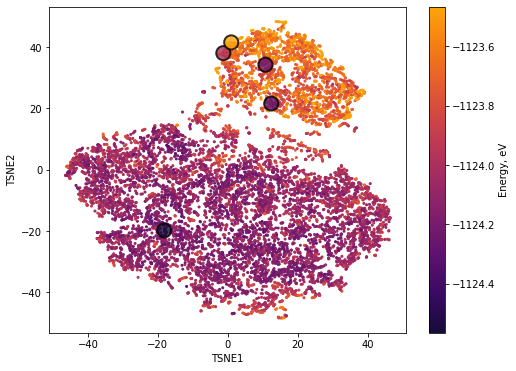

In [40]:
t_tsne=tsne.fit(mean_soaps)
t_tsne_conf=t_tsne.transform(conf_mean_soaps)
plot_embedding(t_tsne, t_tsne_conf, xlabel='TSNE1', ylabel='TSNE2')

!!! Finally, an algorithm that separates the two main sections of the simulation without needing the energies to differentiate them.

## Let's see the results of a few more algorithms.

### Local Linear Embeddings

In [41]:
from sklearn.manifold import LocallyLinearEmbedding as LLE

In [42]:
lle = LLE(n_neighbors=50, n_components=2)
t_LLE = lle.fit_transform(mean_soaps)
t_LLE_conf = lle.transform(conf_mean_soaps)

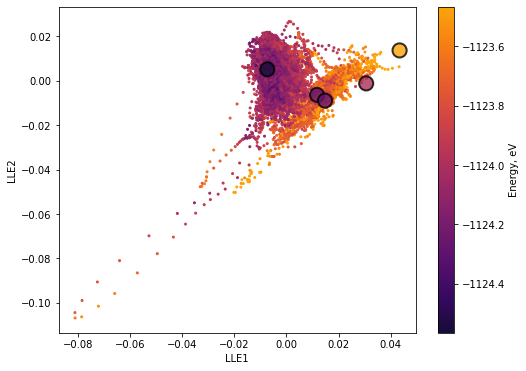

In [43]:
plot_embedding(t_LLE, t_LLE_conf, xlabel='LLE1', ylabel='LLE2')

### ISOMAP

In [44]:
from sklearn.manifold import Isomap as isomap

In [45]:
iso = isomap(n_neighbors=50, n_components=2)
t_iso = iso.fit_transform(mean_soaps)
t_iso_conf = iso.transform(conf_mean_soaps)

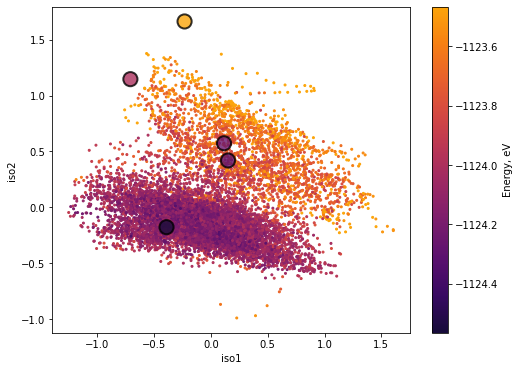

In [46]:
plot_embedding(t_iso, t_iso_conf, xlabel='iso1', ylabel='iso2')

### PCovR

PCovR is a dimensionality reduction technique that balances supervised and unsupervised learning. 
Here, we can use the parameter `mixing` to weight between unsupervised (0) and supervised (1).

In [47]:
from skcosmo.decomposition import PCovR
from sklearn.linear_model import RidgeCV

# In PCovR, we first need to prepare a regression model
# This prevents our decomposition from overfitting on the targets
y = StandardFlexibleScaler(column_wise=True).fit_transform(np.vstack(energy))
Yp = RidgeCV(cv=2, alphas=np.logspace(-10, 2),
             fit_intercept=False).fit(mean_soaps, y).predict(mean_soaps)

In [48]:
pcovr = PCovR(n_components=2, mixing=0.5)
t_pcovr = pcovr.fit(mean_soaps, Yp).transform(mean_soaps)
conf_t_pcovr = pcovr.transform(conf_mean_soaps)

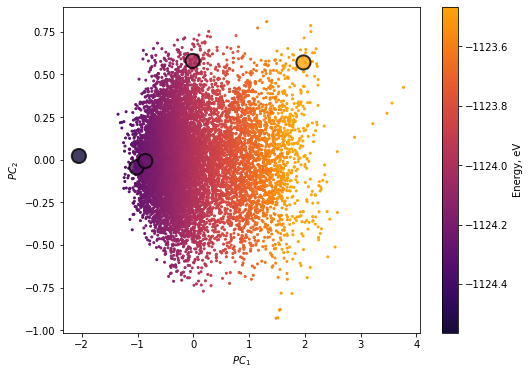

In [49]:
plot_embedding(t_pcovr, conf_t_pcovr)

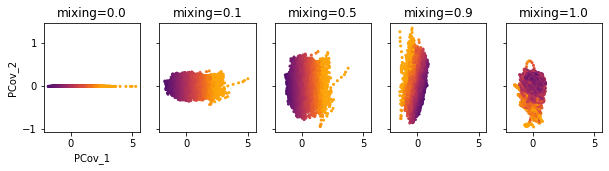

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex=True, sharey=True)
for ax, mixing in zip(axes, [0.0, 0.1, 0.5, 0.9, 1.0]):
    pcovr = PCovR(n_components=2, mixing=mixing)
    T = pcovr.fit(mean_soaps, Yp).transform(mean_soaps)

    ax.scatter(T[:, 0],
               T[:, 1],
               c=energy,
               zorder=-1,
               vmax=max_e,
               vmin=min_e,
               cmap=cmap,
               s=4)

    ax.set_title(f'mixing={round(mixing, 4)}')
axes[0].set_xlabel("PCov_1")
axes[0].set_ylabel("PCov_2")

plt.show()

### Kernel PCovR
PCovR can also be extended for non-linear distance metrics, here we can use our kernel computed in 2.2.

In [51]:
from skcosmo.decomposition import KernelPCovR
from sklearn.kernel_ridge import KernelRidge

Yp = KernelRidge(kernel='precomputed', alpha=1E-4).fit(K, y[idx]).predict(K)
kpcovr = KernelPCovR(n_components=2, mixing=0.5)
t_kpcovr = kpcovr.fit(K, Yp).transform(K)
conf_t_kpcovr = kpcovr.transform(conf_K)

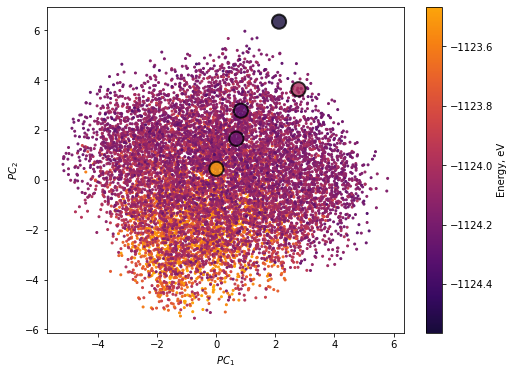

In [52]:
plot_embedding(t_kpcovr, conf_t_kpcovr, idx=idx)

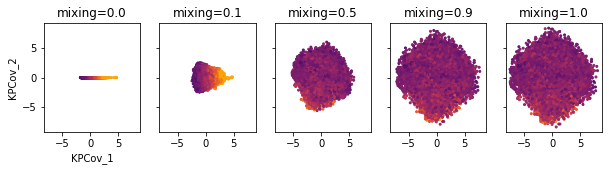

In [53]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex=True, sharey=True)
for ax, mixing in zip(axes, [0.0, 0.1, 0.5, 0.9, 1.0]):
    kpcovr = KernelPCovR(n_components=2, mixing=mixing)
    T = kpcovr.fit(K, Yp).transform(K)

    ax.scatter(T[:, 0],
               T[:, 1],
               c=energy[idx],
               zorder=-1,
               vmax=max_e,
               vmin=min_e,
               cmap=cmap,
               s=4)

    ax.set_title(f'mixing={round(mixing, 4)}')
axes[0].set_xlabel("KPCov_1")
axes[0].set_ylabel("KPCov_2")

plt.show()

## Further Exploration
Now we can export a chemiscope to play around with all of this on [chemiscope.org](chemiscope.org)!

In [54]:
properties = {"PCA": t_pca,
              "KPCA": t_kpca,
              "t-SNE": t_tsne,
              "LLE": t_lle,
              "isomap": t_iso,
              "PCovR": t_pcovr,
              "KPCovR": t_kpcovr,
             }
widget = chemiscope.show(traj, properties)
widget.save('cyclohexanes.json')

NameError: name 't_lle' is not defined